# Distort character images

Program works by loading images from their respective folders in the central data store, applying specified distortions to reduce the quality and then saving the image back to the correct folder.

In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import os
from wand.api import library
import wand.color
import wand.image
import numpy as np
from skimage import measure
# from PIL import Image

data_dir = './source'
img_filetype = '.png'

In [48]:
# Param: file - the filename of the image e.g. 1_1, 3_10, 150_2 etc.
# Returns image as numpy array
def load_image(file):
    img_folder = file[0:file.index('_')]
    img = wand.image.Image(filename=os.path.join(data_dir, img_folder, file)+img_filetype)
    
    im = np.asarray(img)
    if im.shape[2] > 3:
        im = im[:,:,:3]
        
    return im

def binarise_image(im, thresh):
    idx = (im < thresh)
    
    binary_im = np.zeros(im.shape, dtype='int')
    
    binary_im[idx] = 255
    binary_im[~idx] = 0
    
    return binary_im

def extract_character(im):
    binary_im = binarise_image(im, 200) # Input images should be black & white anyway, so 128 is arbitrary
    
    comps = measure.label(binary_im, background=0)
    print('unique labels in comps are ', np.unique(comps))
    
    # make a colour map of random colors
    rand_colors = np.random.rand(256,3)
    rand_colors[0,:] = 0.0 # black at zero index
    rand_cmap = mpl.colors.ListedColormap(rand_colors)

    #print(rand_colors)
    fig = plt.figure(figsize=(10,10))
    plt.imshow(comps, cmap=rand_cmap)
    plt.axis('off')
    plt.show()
    


(480, 640, 4)
(480, 640, 3)


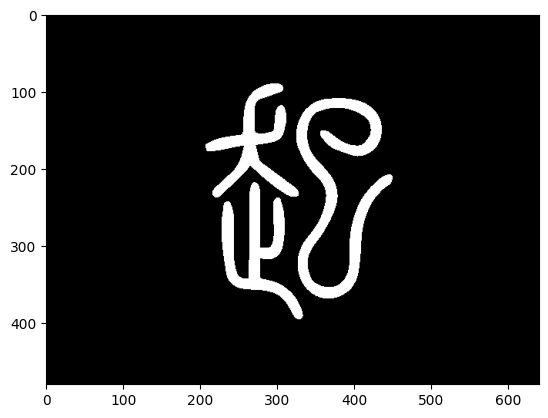

unique labels in comps are  [0 1 2 3]


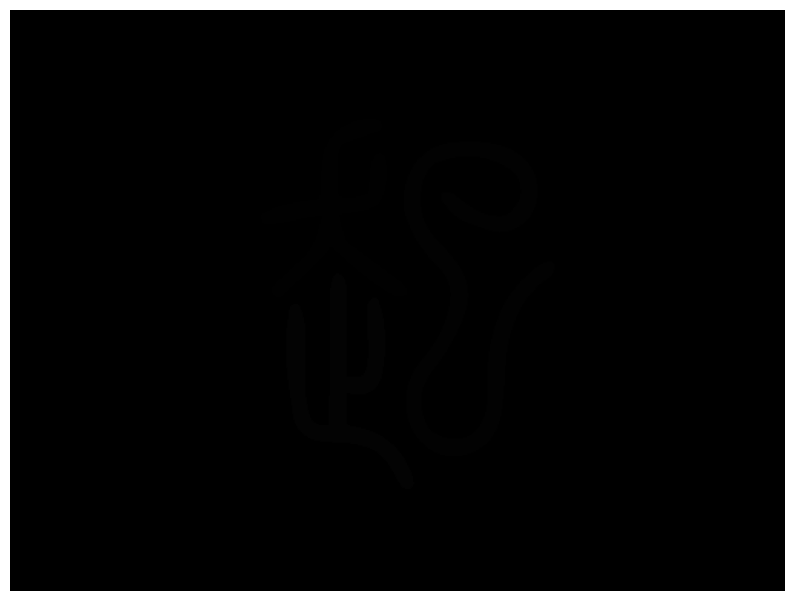

In [47]:
im = load_image('1_1')
print(im.shape)
# plt.imshow(im)
# plt.show()
extract_character(im)

